# Composite systems and interface with QuTIP

B. McDonough

For further documentation of scqubits see https://scqubits.readthedocs.io/en/latest/.

## Set up Hilbert space

In [1]:
import scqubits as scq
import numpy as np
import qutip as qt
from matplotlib import pyplot as plt

In [2]:
import scqubits as scq

#experimental values borrowed from 
# https://journals.aps.org/prx/pdf/10.1103/PhysRevX.11.011010
qbt = scq.Fluxonium(
    EJ = 3.395,
    EC = .479,
    EL = .132,
    flux = .5,
    cutoff = 110,
    truncated_dim=9
)

osc = scq.Oscillator(
    E_osc=5.7,
    truncated_dim=5,
    id_str = 'resonator'
)

hilbertspace = scq.HilbertSpace([qbt, osc])

hilbertspace.add_interaction(
    g_strength = .2,
    op1 = qbt.n_operator,
    op2 = osc.creation_operator,
    add_hc = True
)

hilbertspace.generate_lookup()

# Drive operators
The drive Hamiltonians $H_d^{(i)}$, as discussed, are proportional to the charge number operators $\hat n_i$. These operators are generally off-diagonal with respect to the dressed eigenbasis. In order to simulate the evolution of the system with qutip, these operators first need to be expressed in this basis.

The representation of $\hat n_i$ in the bare energy eigenbasis of the $i^\text{th}$ subsystem can be safely truncated to a level specified by a cutoff parameter in the constructor of the object, since the anharmonicity of the qubit will allow high-lying energy levels to be safely neglected. This offers a speedup for computing the matrix elements in the dressed eigenbasis, which accounts for the contribution of the coupling terms to the energy eigenstates.

In [3]:
#convert an operator from the bare eigenbasis to the dressed eigenbasis
def bare_to_dressed(operator, hilbertspace):
    evecs, = hilbertspace["evecs"]
    return operator.transform(evecs)

def basis_change(operator, subsystem, hilbertspace, dressed_eigenbasis = True):
    """This method can be used to express a subsystem operator in the dressed energy eigenbasis
    of the full hilbertspace, expecially useful for simulations in QuTiP.

    Args:
        operator (Qobj): A subsystem operator with dimension cutoff x cutoff
        subsystem (Qubit or Resonator): The subsystem acted on by the operator
        hilbertspace (HilbertSpace): The Hilbert space representing the composite system

    Returns:
        (Qobj): An operator with the same dimension as the HilbertSpace
    """

    #Get bare eigenvectors of subsystem stored in hilbertspace
    hilbertspace.bare_eigenstates(subsystem) #TODO: figure out why this needs to be run twice to work
    bare_evecs, = hilbertspace.bare_eigenstates(subsystem)
    #Express operator in bare eigenbasis and tensor with appropriate identities
    op_id_wrap = scq.identity_wrap(operator, subsystem, hilbertspace.subsys_list, evecs = bare_evecs)
    #Get full dressed eigenbasis
    evecs, = hilbertspace["evecs"]
    if dressed_eigenbasis:
        evecs, = hilbertspace["evecs"]
        return bare_to_dressed(op_id_wrap, hilbertspace)
    else:
        #Transform wrapped operator into dressed eiegenbasis
        return op_id_wrap

In [5]:
hilbertspace.energy_by_bare_index((0,1)) #There might be an issue with this method

AttributeError: 'numpy.ndarray' object has no attribute '_parameters'

In [6]:
#resonator charge operator
phi_r = basis_change(osc.annihilation_operator()+osc.creation_operator(), osc, hilbertspace)
#qubit charge operator
n_qbt = basis_change(qbt.n_operator(), qbt, hilbertspace)

## Driving Simulation in QuTIP
Now that the operators are obtained in the new energy eigenbasis, qutip's `sesolve` or `mesolve` functionality can be used to simulate the time dynamics associated with driving the system. In the case of the Fluxonium, the $\hat n$ operator acts like a $\sigma_x$ operator on the first two energy eigenstates, transitioning between them. We may drive transitions between these two states by choosing the drive frequency $\omega_d$ to be the resonant frequency of the qubit.

The drive can either be applied to the qubit directly or to the resonator. Since the frequency of the resonator is detuned from the frequency of the qubit, the qubit may be driven directly without creating photons in the resonator, and virtual excitations can be created in the resonator to drive the qubit.

In [21]:
s0, = hilbertspace.dressed_index((3,0))
s1, = hilbertspace.dressed_index((1,1))

In [22]:
import numpy as np
import qutip as qt

Omega = 2*np.pi*.04 #Drive strength in GHz
#0-1 transition frequency of the qubit
wd = hilbertspace.energy_by_dressed_index(s1)[0] - hilbertspace.energy_by_dressed_index(s0)[0]

#time-dependent drive e(t)
def drive_coeff(t, args):
    omega_d = args['omega_d']
    return Omega*np.cos(wd*t)

#Hamiltonian is the interaction Hamiltonian plus the drive Hamiltonian 
evals, = hilbertspace["evals"]
diag_dressed_hamiltonian = qt.Qobj(np.diag(evals), dims = [hilbertspace.subsystem_dims]*2)
H_qbt_drive = [diag_dressed_hamiltonian,[phi_r, drive_coeff]]

In [25]:
state0 = qt.basis(45,s0)
state1 = qt.basis(45,s1)
tlist = np.linspace(0, 10000, 10000)
result = qt.sesolve(H_qbt_drive, state0, tlist, e_ops = [state0*state0.dag(), state1 * state1.dag()], args = {"omega_d": wd})

Text(0, 0.5, '|0>')

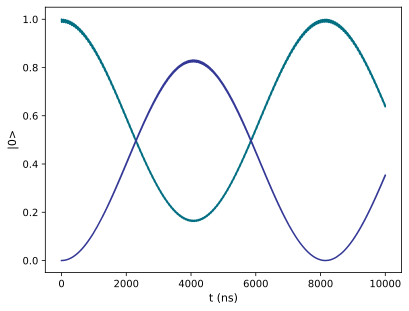

In [26]:
plt.plot(tlist, result.expect[0])
plt.plot(tlist, result.expect[1])
plt.xlabel("t (ns)")
plt.ylabel("|0>")

Fluxonium Reset Procedure

The Fluxonium qubit has a transition frequency between the computational states which is significantly lower than that of the transmon. The low transition frequency results in relaxation to the mixed state at equilibrium. A Transmon naturally relaxes into the ground state, so initializing qubits is trivial. With Fluxonium, an active reset procedure is necessary.

This procedure contemplates a Fluxonium qubit weakly coupled to a resonator. Because of the weak coupling, it is still appropriate to keep the product-state labeling of the dressed eigenstates. The system is in a mixed state consisting of almost equal populations of $|g0\rangle$ and $|e0\rangle$ at equilibrium. Then, transitions are driven simultaneously between $|g0\rangle \to |h_0\rangle$ and $|h0\rangle \to |e1\rangle$, making use of the large $\langle h0 | \hat n_f | e1 \rangle$ operator element. The resonator has a low quality factor, and so photon loss brings the $|e1\rangle$ state to $|e0\rangle$ quickly with respect to the relaxation time of the Fluxionium. This results in a preparation of the $|e0\rangle$ state with high fidelity.

In [12]:
g0 = hilbertspace.bare_productstate((0,0))
e0 = hilbertspace.bare_productstate((1,0))
mixed_state = .5*(g0*g0.dag()+e0*e0.dag())

In [13]:
Omega = 2*np.pi*.01 #Drive strength in GHz
#0-1 transition frequency of the qubit

In [14]:
hilbertspace.generate_lookup()

In [15]:
w0 = hilbertspace.energy_by_dressed_index(dressed_index((qbt,1),(osc,0)))[0] - hilbertspace.energy_by_dressed_index(dressed_index((qbt,0),(osc,0)))[0]

In [16]:
w0

0.007399399718663213

In [17]:
hilbertspace.energy_by_dressed_index(dressed_index((qbt,1),(osc,0)))[0] - hilbertspace.energy_by_dressed_index(dressed_index((qbt,0),(osc,0)))[0]

0.007399399718663213

In [22]:
hilbertspace.eigenvals()

array([-1.25032295, -1.24292355,  1.34506805,  1.53226147,  3.78740973,
        3.8611065 ])

In [19]:
Omega = .02
def drive_coeff(t, args):
    omega_d = args['omega_d']
    return Omega*np.cos(omega_d*t)


diag_dressed_hamiltonian = qt.Qobj(np.diag(evals), dims = [hilbertspace.subsystem_dims]*hilbertspace.subsystem_count)
H_drive = [diag_dressed_hamiltonian,[phi_r, drive_coeff]]

In [20]:
states = [hilbertspace.bare_productstate((0,i)) for i in range(4)]

tlist = np.linspace(0, 3000, 5000)
result = qt.sesolve(H_drive, states[0], tlist, e_ops = [state*state.dag() for state in states], args = {"omega_d": w0})

Text(0, 0.5, '|0>')

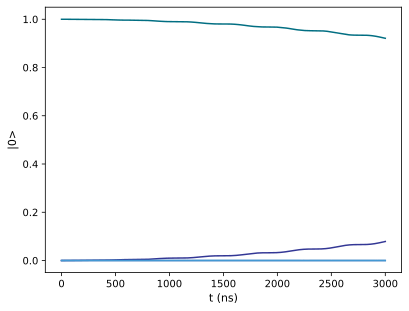

In [21]:
plt.plot(tlist, result.expect[0])
plt.plot(tlist, result.expect[1])
plt.plot(tlist, result.expect[2])
plt.plot(tlist, result.expect[3])
plt.xlabel("t (ns)")
plt.ylabel("|0>")